## Exercise 6 Homework

In this homework we will try to confuse a pretrained network with crazy transformations


In [1]:
# Imports
!pip install --upgrade -q gspread
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision
import numpy as np
import random

import datetime
import pytz

tz = pytz.timezone('Europe/Berlin')

gc = gspread.authorize(GoogleCredentials.get_application_default())

homework_done = False

The first time you run this there is probably an error. Just click on "RUNTIME" --> "RESTART RUNTIME" and run this cell again.

In [2]:
#@title Result Form
gsheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/1i1lLpburGOuTb5wGx88cuQi0ItA7JOjoNIRbBhEyaH0/edit#gid=1494605435")

def write_result(task_number, result=None):
  worksheet = gsheet.worksheet(f"homework{task_number}")
  current_time = datetime.datetime.now(tz).strftime("%X")
  current_date = str(datetime.date.today())
  if result:
    worksheet.append_row([student_name, current_time, current_date, result])
    print(f"Task {task_number} successfully solved by {student_name} at {current_time} with result: {result}")
  else:
    worksheet.append_row([student_name, current_time, current_date])
    print(f"Task {task_number} successfully solved by {student_name} at {current_time}")

print("Reporting enabled - write_result(number_of_task, result='your result') ")

Reporting enabled - write_result(number_of_task, result='your result') 


In [3]:
import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Download our "dataset" - its really just some cat and dog images
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat.jpg
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat2.jpg
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat3.jpg
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat4.jpg
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat5.jpg
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat6.jpg
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat7.jpg
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat8.jpg
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat9.jpg
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/dog1.jpg
!wget https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/dog2.jpg



cpu
--2020-11-26 18:22:30--  https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50718 (50K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  49.53K  --.-KB/s    in 0.01s   

2020-11-26 18:22:30 (3.80 MB/s) - ‘cat.jpg’ saved [50718/50718]

--2020-11-26 18:22:30--  https://raw.githubusercontent.com/IFL-CAMP/AI4MDs_21/main/images/cat2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 483969 (473K) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.j

In [4]:
### TODO: Type in your name you need this to submit your exercise ###
student_name = "dd"
assert student_name != "yourName"

In [5]:
from PIL import Image

file_names = ["cat.jpg", "cat2.jpg", "cat3.jpg", "cat4.jpg", "cat5.jpg", "cat6.jpg", "cat7.jpg", "cat8.jpg", "cat9.jpg", "dog1.jpg", "dog2.jpg"]

def imshow(img):
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.axis('off')
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

cats_org = []
for i in file_names:
  temp_im = Image.open(i)
  cats_org.append(temp_im)

cats_labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1] # The value is one if there is an outlier e.g. a dog. So cat=0 and dog=1
cats_labels = np.asarray(cats_labels)
print(f"cats_labels: {cats_labels}")

cats_labels: [0 0 0 0 0 0 0 0 0 1 1]


In [6]:
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

# Standard transform we learned in the last lecture
cat_transform = transforms.Compose([
                                  # resize image to the network input size
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(norm_mean, norm_std),
                                   ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


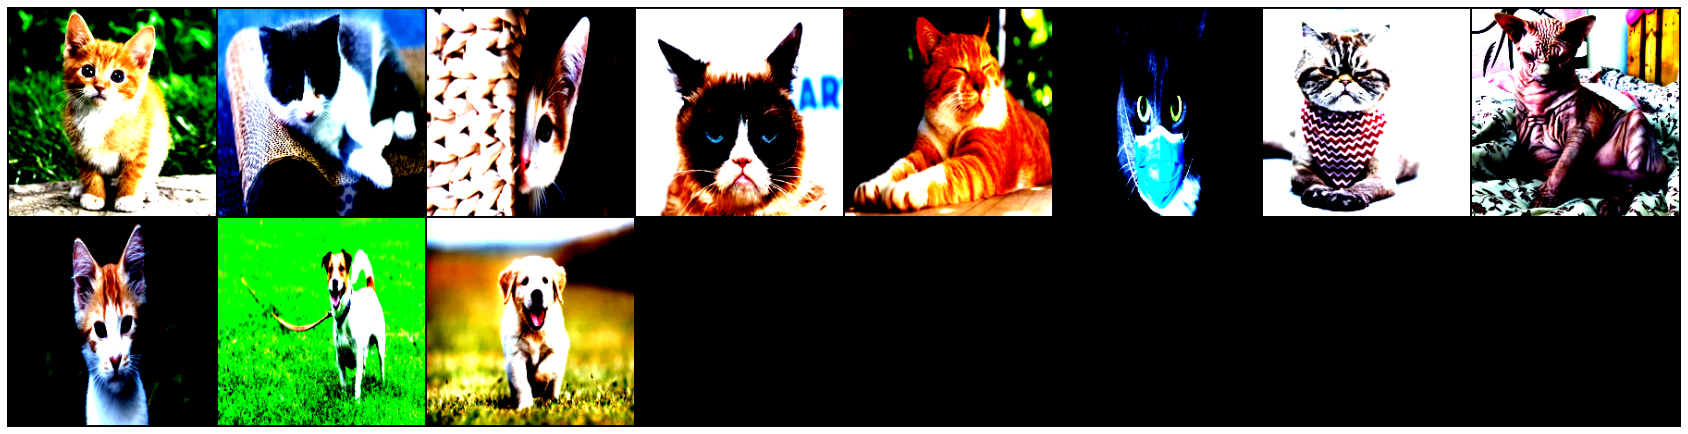

In [7]:
# As you can see the two last pictures are not cats but dogs.

cats = []

for i in cats_org:
  cats.append(cat_transform(i))

imshow(torchvision.utils.make_grid(cats))
cats_tensor = torch.stack(cats)

In [8]:
## Loading a Neural Network
model = torchvision.models.resnet18(pretrained = True) # This is a very well known network but it is designed for 1000 classes and not just cats and dogs this is why we need the next line
model.fc = nn.Sequential(nn.Linear(512,256),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(256,2),
                         nn.LogSoftmax(dim=1))

state_dict_trained = torch.hub.load_state_dict_from_url('https://github.com/IFL-CAMP/AI4MDs_21/raw/main/checkpoints/dogs-vs-cats.pth', model_dir=".", map_location = device) # This is a checkpoint to a trained cat and dog model that works pretty well



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://github.com/IFL-CAMP/AI4MDs_21/raw/main/checkpoints/dogs-vs-cats.pth" to ./dogs-vs-cats.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [9]:
model.load_state_dict(state_dict_trained["state_dict"]) ## Here we load the trained weights (state_dict) in our model 
model.eval() # This puts our model in eval mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# Lets try the model
with torch.no_grad(): # during testing we dont learn so we dont need to calculate the gradient for learning
  outputs=model(cats_tensor) # That is a forward pass to a network
outputs = torch.exp(outputs) # transform the output to probabilities
pred = torch.argmax(outputs, dim=1).cpu().numpy()  # here we take the highest probabily and get the index 0 was cat and 1 was dog

# Lets checkout the predictions of the network
print(f"outputs: {outputs}")
print(f"pred: {pred}")
# [0.8978, 0.1022] means that the network thinks that the true class is index 0 with a probably of (89%)

outputs: tensor([[0.8978, 0.1022],
        [0.9025, 0.0975],
        [0.6908, 0.3092],
        [0.8798, 0.1202],
        [0.8826, 0.1174],
        [0.8425, 0.1575],
        [0.9316, 0.0684],
        [0.6509, 0.3491],
        [0.8302, 0.1698],
        [0.1965, 0.8035],
        [0.2462, 0.7538]])
pred: [0 0 0 0 0 0 0 0 0 1 1]


In [11]:
# Lets make accuracies out of this
acc = np.sum(cats_labels == pred, dtype=float) # here we compare the TRUE cats_labels with the PREDICTED pred and sum up how often pred was correct
acc = acc/len(pred)  # here we divide by lenght to get the ratio between correctly classified and total amount of images

print(f"The Accuracy is {acc * 100}%")
# As you can see the network predicted all cats and all dogs correctly...

The Accuracy is 100.0%


# Homework
Modify the Transformation so that the resulting accuracy drops below 100%
This might a bit challenging. Try to find an augmentation that screws up the accuracy while for you the image is still recognizable.

Feel free to check out different augmentation libraries like albumentations : https://github.com/albumentations-team/albumentations

Once your acc drops below 1.0 your submit your homework.

In [12]:
###### TODO START #######
# Add or remove transformations to confuse the prediction
confuse_transform = transforms.Compose([
                                  # resize image to the network input size
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(norm_mean, norm_std),
                                   ])
###### TODO END #######
# Run the next cell to test your transformations.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


outputs: tensor([[0.8978, 0.1022],
        [0.9025, 0.0975],
        [0.6908, 0.3092],
        [0.8798, 0.1202],
        [0.8826, 0.1174],
        [0.8425, 0.1575],
        [0.9316, 0.0684],
        [0.6509, 0.3491],
        [0.8302, 0.1698],
        [0.1965, 0.8035],
        [0.2462, 0.7538]]) 
 The Accuracy is 100.0%


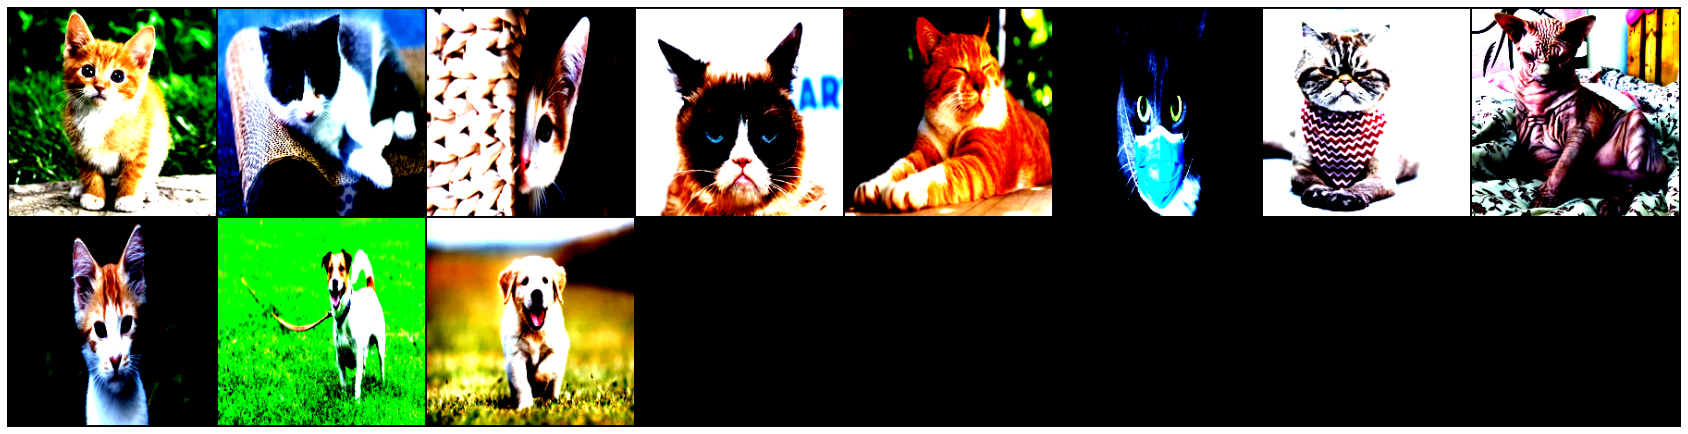

In [13]:
cats = [] # Here i delete all previous cats
for i in cats_org: 
  cats.append(confuse_transform(i)) # Apply transformation to each image and save it to list

imshow(torchvision.utils.make_grid(cats)) # show the images

cats_tensor = torch.stack(cats) # make them to a tensor (from list to tensor)

with torch.no_grad(): # during testing we dont learn so we dont need to calculate the gradient for learning
  outputs=model(cats_tensor)  # That is a forward pass to a network
outputs = torch.exp(outputs) # transform the output to probabilities
pred = torch.argmax(outputs, dim=1).cpu().numpy() # here we take the highest probabily and get the index 0 was cat and 1 was dog
acc = np.sum(cats_labels == pred, dtype=float) # here we compare the TRUE cats_labels with the PREDICTED pred and sum up how often pred was correct
acc = acc/len(pred) # here we divide by lenght to get the ratio between correctly classified and total amount of images

print(f"outputs: {outputs} \n The Accuracy is {acc * 100}%" )

if acc < 1.0:
  homework_done = True
  homework_acc = acc
  print(f"Homework done with acc: {homework_acc}") ### Try to minimize this accuracy while you are still capable of identifying the cats & dogs correctly

In [14]:
if homework_done:
  write_result(1, str(confuse_transform))
else:
  print("you didnt solve all exercises yet")

you didnt solve all exercises yet
